## LSST Afterglow detection metrics

Notebook for a mocked up GRB afterglow lightcurve. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [1]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False

### On-axis afterglows

On-axis afterglows decay as $F \sim t^{-\alpha}$ until a jet break, with $\alpha \sim 1$.

This requires subclassing `TransientMetric`, which assumes linear rise & decays in magnitude. We therefore have writted `GRBTransientMetric` that synthesizes the appropriate lightcurve shape.

We will use the rough numbers in 2011PASP..123.1034J: a Gaussian with $\mu$=15.35 mag, $\sigma=1.59$ in R-band at 1 minute after explosion, $\alpha = 1.0$.  
The right way to do this is not to assume fiducial values, but to simulate a cosmological population of events.


### GRBTransientMetric

In [3]:
from mafContrib import GRBTransientMetric

Let's look at a single year of the survey--we'll normalize our detection rates per year.

In [4]:
year = 8

Now let's plot the lightcurves.  Because we include a random draw from the brightness distribution these plots will change each time we re-execute the cell.

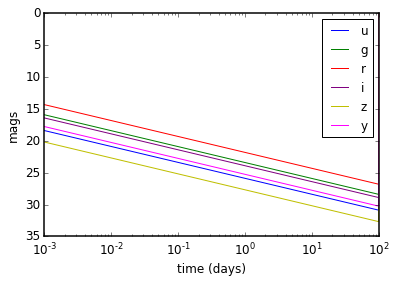

In [5]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 100 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=1, transDuration=transDuration)


times = np.logspace(-3,2,500)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.legend()

In [6]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of transients are detected at least once?
metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [7]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
# sqlconstraint='night > 0' # needed to get Plane, NEP extensions, but screws up rate calc?
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 2922.000000 and 3287.250000
Found 250549 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night between 2922.000000 and 3287.250000 sqlconstraint now.
monopole: 0.511816  dipole: lon: 92.1253, lat: -38.5372, amp: 0.135427
Plotting complete.


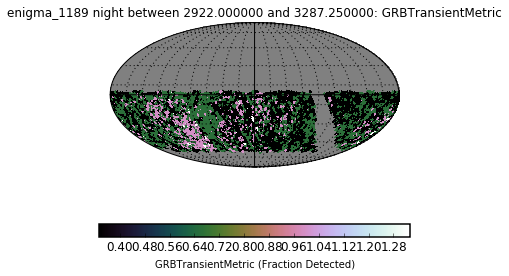

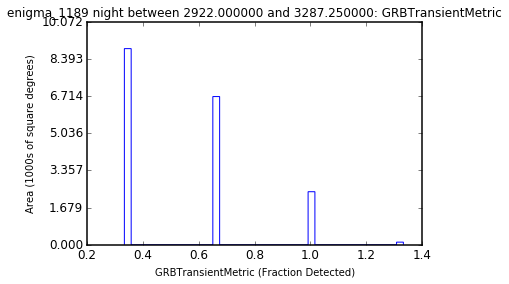

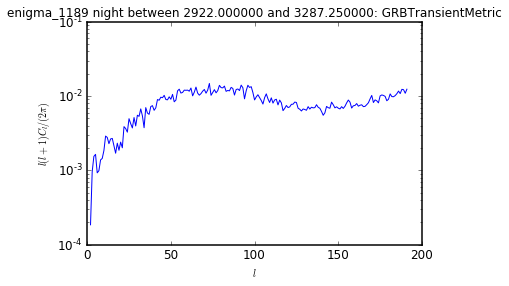

In [8]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [9]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

GRBTransientMetric {'Median': 0.66666666666666663}


So about two thirds of these afterglows would be detected in at least one epoch.

Now ask how many we can detect with 3 points per lightcurve (no restriction on same band, because TransientMetric doesn't allow it.)

In [16]:
transMetric = GRBTransientMetric(alpha= 1., surveyDuration=1, nPerLC=3)

sqlconstraint = 'night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 2922.000000 and 3287.250000
Found 250549 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night between 2922.000000 and 3287.250000 sqlconstraint now.
monopole: 0.0393758  dipole: lon: -64.6497, lat: 42.5077, amp: 0.00652049
Plotting complete.


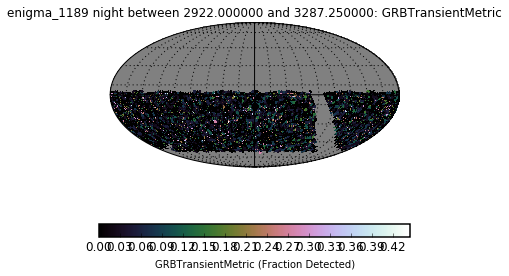

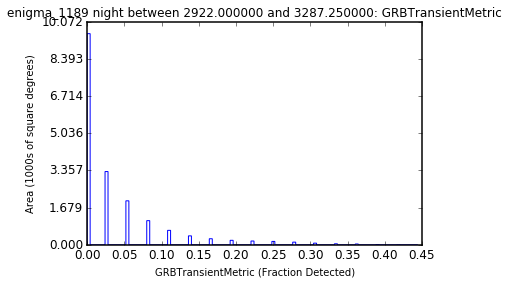

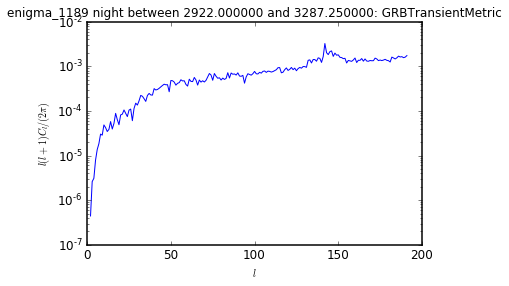

In [17]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)


In [18]:
transBundle.summaryValues

{'Median': 0.0}

So demanding three detections (in any filter) drops us to a 0% median detection rate.  Two detections is at 11%

### GRB Decay Rates and LSST revist times

Let's try to understand these detection efficiencies by looking more generically at how often we have three observations in a single filter within a relevant interval to detect a GRB.

We'll start by determining how long LSST can observe afterglows parameterized as above--this is be band-dependent, as both LSST's limiting magnitude and the afterglow color vary.  For simplicity we consider just $r$ band for now.

3.96226973493


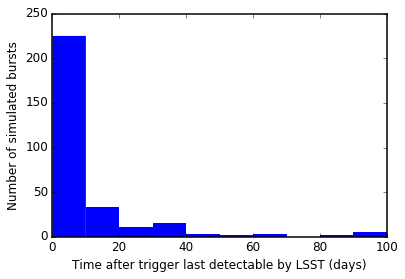

In [19]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 300 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=1, transDuration=transDuration)



def find_time_at_limiting_mag(limiting_mag,times,lc):
    return np.interp(limiting_mag,lc,times)

limit_times = []
lc_mins = []
#times = np.linspace(0,transDuration+1,500)
times = np.logspace(-2,2,500)
for i in range(300):
    # since we haven't included band-dependent afterglow brightness yet, 
    # look at the brightness distribution as a function of time in a single band
    filters = np.array(['r']*times.size)
    lc = transMetric.lightCurve(times,filters)
    lc_mins.append(lc[-1])
    limit_times.append(find_time_at_limiting_mag(24.7,times,lc))
#    plt.plot(times,lc)
#plt.xlabel('time (days)')
#plt.ylabel('mags')
#plt.gca().invert_yaxis()
#plt.xscale('log')
plt.hist(limit_times)
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Number of simulated bursts')

print np.percentile(limit_times,50)

So there is a substantial tail of afterglows detectable to tens or even hundreds of days after the burst.  Let's look at the cumulative histogram:

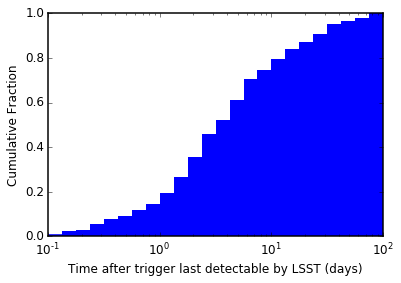

In [20]:
plt.hist(limit_times,normed=True,cumulative=True,bins=np.logspace(-1,2,25))
plt.xscale('log')
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Cumulative Fraction')

It is important to remember that we have not included a jet break in our lightcurve model here--in reality we expect the afterglow decay to decay faster at late times.  Still, it does appear that with appropriately-chosen cadences it should be possible to detect afterglows in multiple visits.